# LUS-CS433

## 1. Code Exploration

### Imports

In [1]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import seaborn as sns

### Downloading data

## 2. Data Exploration

In [3]:
diagnostics = pd.read_csv('labels_diagnostic.csv')

In [4]:
# getting the list of names
!ls LUS\ images/negative > neg_names.csv
!ls LUS\ images/positive > pos_names.csv

neg = pd.read_csv('neg_names.csv', header=None)
pos = pd.read_csv('pos_names.csv', header=None)

data = neg.append(pos, ignore_index=True)
data

ls: cannot access 'LUS\': No such file or directory
ls: cannot access 'images/negative': No such file or directory
ls: cannot access 'LUS\': No such file or directory
ls: cannot access 'images/positive': No such file or directory


EmptyDataError: No columns to parse from file

In [ ]:
pos = pd.read_csv('pos_names.csv', header=None)

# removing .png extension
pos[0] = pos[0].apply(lambda x: x[:-4])

# extracting site
pos[0] = pos[0].apply(lambda x: x.split('_')[2])

pos

,0
0,QAID
1,QAID
2,QAIG
3,QAIG
4,QASD
...,...
2337,QPIG
2338,QPSD
2339,QPSD
2340,QPSG


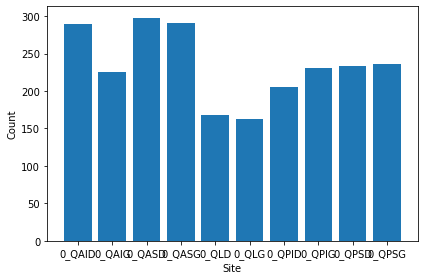

In [ ]:
sums = pd.get_dummies(pos).sum()

plt.bar(sums.index, sums.values)
plt.xlabel('Site')
plt.ylabel('Count')
plt.tight_layout()

## 3. Apply mask on Data and sort files

In [14]:
! mkdir data/LUS_proc_images
! mkdir data/LUS_proc_images/train
! mkdir data/LUS_proc_images/val
! mkdir data/LUS_proc_images/train/true
! mkdir data/LUS_proc_images/train/false
! mkdir data/LUS_proc_images/val/true
! mkdir data/LUS_proc_images/val/false 

In [8]:
x = cv2.imread('data/LUS images/negative/117_QAIG_1.png')

In [9]:
nb_rows, nb_cols, rgb = x.shape
nb_cols791 = 791
print(nb_rows, nb_cols)

1080 804


In [10]:
# TODO comment

#Create a mask for all images
mask804 = np.zeros([1080, 804,3])
for row in range(nb_rows):
    for col in range(nb_cols):
        if row > 25 and row < 1010 and col < 762 and (-4/5 * row) + 300 < col and (4/5 * row) + len(x[0])-300 > col:
            mask804[row, col] = [1,1,1]


In [11]:
mask791 = np.zeros([1080,791, 3])
for row in range(nb_rows):
    for col in range(nb_cols791):
        if row > 25 and row < 1010 and col < 762 and (-4/5 * row + 293) < col and (4/5*row) + len(x[0])-293 > col:
            mask791[row, col] = [1,1,1]

In [126]:
mask792 = np.zeros([1080,792, 3])
for row in range(nb_rows):
    for col in range(792):
        if row > 25 and row < 1010 and col < 762 and (-4/5 * row + 293) < col and (4/5*row) + len(x[0])-293 > col:
            mask792[row, col] = [1,1,1]

In [76]:
import glob
def create_samples(num_samples, ratio, path):
    images_path = glob.glob(path)
    train = int(num_samples * ratio)
    a = np.zeros((1080,3))
    b = np.zeros((1080,792,3))
    b[:,-1] = a
    for i, image in enumerate(images_path[:num_samples]):
        cv2_img = cv2.imread(image)
        if (len(cv2_img[0]) == 791):
            b[:,:-1] = (cv2_img * mask791)
            masked_img = b
        else:
            masked_img = (cv2_img * mask804)[6:798]
        
        # Selecting image name from path name
        im_name = image.split("/")[-1]
        #Disgusting but had problem because name was negative\\file_name
        im_name = im_name[9:]
        
        if i >= train:
            cv2.imwrite(f"data/LUS_proc_images/val/true/{im_name}", masked_img)
        else:
            cv2.imwrite(f"data/LUS_proc_images/train/true/{im_name}", masked_img)

In [77]:
#Make sure that the files are empty
! rm -rfv data/LUS_proc_images/val/true/*
! rm -rfv data/LUS_proc_images/train/true/*

In [78]:
#Generates the samples!
num_samples = 1245
ratio = 0.8
path = "data/LUS images/negative/*.png"
create_samples(num_samples, ratio, path)

In [155]:
active_792 = np.sum(mask792)/3

In [187]:

def compute_mean_std(img, mask):
    len_x,len_y, dim = mask.shape
    mean = cv2.mean(img)[0] * (1080 * 792/active_792)
 
    std = 0
    for x in range(len_x-1):
        for y in range(len_y-1):
            if(mask[x,y][0] == 1):
                std += (img[x,y][0] - mean)**2
    
    std = np.sqrt(std/active_792)
    
    return mean,var
            

#### Compute mean brightness over all sample

In [188]:


def create_brightness_df(path):
    df = pd.DataFrame(columns = ['mean', 'std'])
    images_path = glob.glob(path)
    active_792 = np.sum(mask792)/3
    for i,image in enumerate(images_path):
        img = cv2.imread(image)
        m, s = cv2.meanStdDev(img)
        print(m,s)
        df.loc[i] = [m[0,0], s[0,0]]
        print(compute_mean_std(img,mask792))
        break
        
    return df

In [189]:
df = create_brightness_df("data/LUS_proc_images/train/true/*.png")

[[34.20292163]
 [34.20292163]
 [34.20292163]] [[46.1725986]
 [46.1725986]
 [46.1725986]]
1080 792
43.66284805030173


IndexError: index 792 is out of bounds for axis 0 with size 792

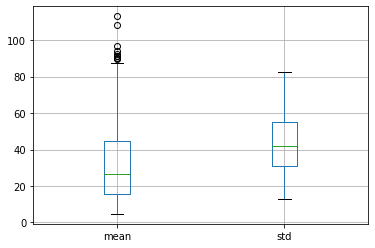

In [16]:
df.boxplot()

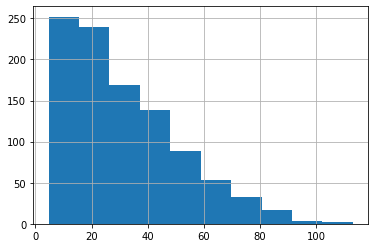

In [17]:
df['mean'].hist()

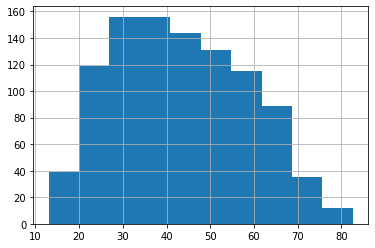

In [18]:
df['std'].hist()

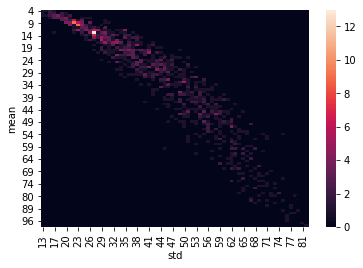

In [19]:
df2 = df.astype(int)
df2 = pd.crosstab(df2['mean'], df2['std'])
sns.heatmap(df2)

In [20]:
# TODO comment
def split_video(video_path):
    video = cv2.VideoCapture(video_path)
    i = 0
    df_video = pd.DataFrame(columns = ['mean', 'std'])
    while(video.isOpened()):
        ret, image = video.read()
        if ret == True:
            video.set(cv2.CAP_PROP_POS_MSEC,(i*1000))
            image = image * mask792 #we know it's 792
            m, s = cv2.meanStdDev(image)
            df_video.loc[i] = [m[0,0], s[0,0]]
            i += 1
        else:
            break
    video.release()
    return df_video

In [22]:
"""# Renaming to appropriate format
def replace_dot_by_underscore(path):
    path_list = glob.glob(path)
    
    for old_path in path_list:
        new_path = old_path.replace(".", "_", 1)
        os.rename(old_path, new_path)
        
replace_dot_by_underscore("data/Ultrason butterflynetwork/*")"""

In [23]:
df_split = split_video("data/Ultrason butterflynetwork/1_1_QAID_1.mp4")

In [25]:
df_split

,mean,std
0,13.626837,33.396776
1,13.626837,33.396776
2,13.596254,33.613039
3,13.859770,34.045651
4,13.413530,33.645666
5,13.392406,33.487103
6,9.964788,30.747767
7,13.275161,32.323239
8,16.277448,35.185978
9,15.971615,34.889776


In [134]:
df_split = split_video("data/Ultrason butterflynetwork/1_9_QLD.mp4")

In [49]:
df_video2 = df_video.astype(int)
df_video2 = pd.crosstab(df_video2['mean'], df_video2['std'])
sns.heatmap(df_video2)

ValueError: zero-size array to reduction operation fmin which has no identity

In [ ]:
df_video.head(20)

,mean,std
0,37.864373,57.183505
1,37.115139,56.459659
2,36.875601,56.347352
3,36.314428,56.145268
4,35.674874,55.818582
5,35.115213,55.344910
6,34.517314,55.151923
7,34.099862,54.916397
8,34.293143,55.196529
9,34.775807,55.572057
